# 1. 检查依赖项的安装和设置

In [207]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
aiohappyeyeballs             2.4.4
aiohttp                      3.11.10
aiosignal                    1.2.0
asttokens                    3.0.0
astunparse                   1.6.3
async-timeout                5.0.1
attrs                        24.3.0
blinker                      1.9.0
Brotli                       1.0.9
cachetools                   5.5.1
certifi                      2025.6.15
cffi                         1.17.1
charset-normalizer           3.3.2
click                        8.1.8
colorama                     0.4.6
comm                         0.2.1
contourpy                    1.3.1
cryptography                 41.0.3
cycler                       0.11.0
debugpy                      1.8.11
decorator                    5.1.1
exceptiongroup               1.2.0
executing                    0.8.3
flatbuffers                  24.3.25
fonttools                    4.55.

In [208]:
import tensorflow as tf
import os

In [209]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [210]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2.删除不合格的图像

In [211]:
import cv2
import imghdr  #用于检查文件的格式

In [212]:
data_dir = 'data' #数据集目录

In [213]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [214]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path) # 读取图像
            tip = imghdr.what(image_path) # 获得图像类型
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path) # 删除该图像
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

# 3. 加载数据

In [215]:
import numpy as np
from matplotlib import pyplot as plt

In [216]:
data = tf.keras.utils.image_dataset_from_directory(
    'data',image_size=(256,256),batch_size=32,shuffle=True,seed=111)#设置随机打乱并设置随机种子

Found 1139 files belonging to 2 classes.


In [217]:
data_iterator = data.as_numpy_iterator()

In [218]:
batch = data_iterator.next() # 小批次 批次大小为32 图片+标签

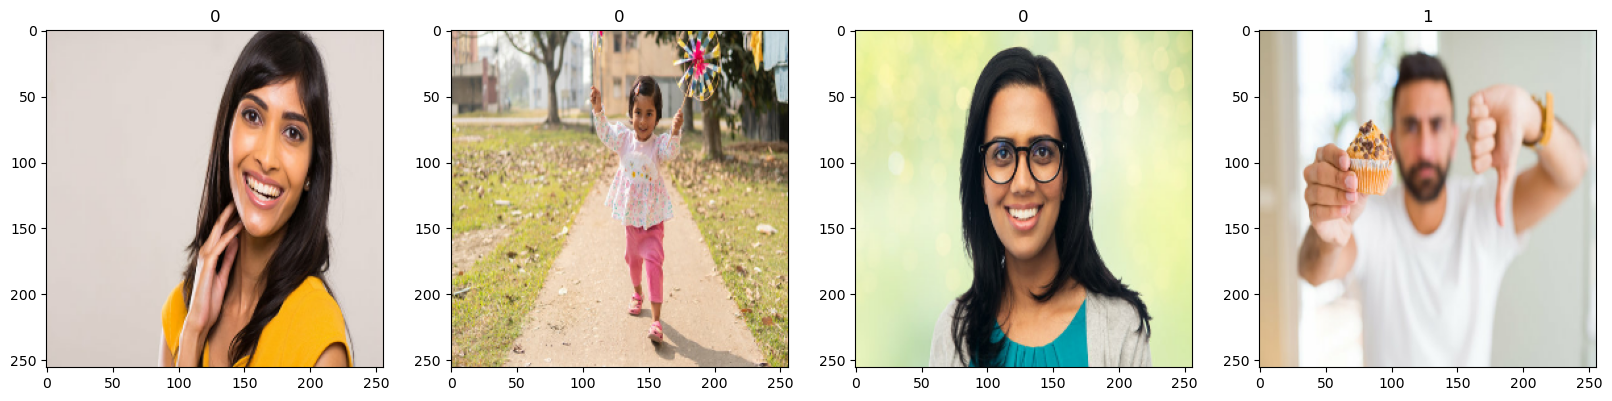

In [219]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
# happy:0  sad:1

# 4. 缩放数据

In [220]:
data = data.map(lambda x,y: (x/255, y))

In [221]:
data.as_numpy_iterator().next()

(array([[[[9.51091468e-01, 9.18304801e-01, 8.44509244e-01],
          [9.72052574e-01, 8.95451307e-01, 8.21574867e-01],
          [9.40444529e-01, 8.92619789e-01, 7.96490133e-01],
          ...,
          [9.86199856e-01, 9.48189080e-01, 9.41033840e-01],
          [9.71813738e-01, 9.27144587e-01, 9.23161745e-01],
          [9.71813738e-01, 9.27144587e-01, 9.23161745e-01]],
 
         [[8.96656692e-01, 8.37847531e-01, 7.04573572e-01],
          [8.72695982e-01, 7.71844387e-01, 5.81109285e-01],
          [8.50929677e-01, 7.78084815e-01, 5.76970339e-01],
          ...,
          [9.93239701e-01, 9.60661769e-01, 9.60325241e-01],
          [9.91482854e-01, 9.56188738e-01, 9.31801498e-01],
          [9.91482854e-01, 9.56188738e-01, 9.31801498e-01]],
 
         [[8.69723678e-01, 7.80143678e-01, 6.14753783e-01],
          [8.26429427e-01, 6.87611997e-01, 4.03645843e-01],
          [8.20618868e-01, 7.06066191e-01, 4.20114785e-01],
          ...,
          [9.84026968e-01, 9.61617291e-01, 9.4960

# 5. 划分数据集

In [222]:
len(data)  # 数据批次

36

In [236]:
train_size = int(len(data)*0.6+1)  
val_size = int(len(data)*0.2)   
test_size = int(len(data)*0.2) 

In [224]:
print('训练集：验证集：测试集 = ',train_size,':',val_size,':',test_size)

训练集：验证集：测试集 =  22 : 7 : 7


In [225]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. 构建模型

In [226]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [227]:
model = Sequential()

In [228]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
#加入DropOut
model.add(Dropout(0.25))  # 25%的神经元在训练时随机失活
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
# Dropout 层插入于第二个卷积块后
model.add(Dropout(0.25))
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
# Dropout 层插入于全连接层之后
model.add(Dropout(0.5))  # 防止最后几层强拟合训练集特征
model.add(Dense(1, activation='sigmoid'))

In [229]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [230]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 127, 127, 16)      0         
                                                                 
 conv2d_15 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 62, 62, 32)       

# 7. 训练模型

In [231]:
logdir='logs'

In [232]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [233]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
22/22 [==============================] - 8s 281ms/step - loss: 0.7362 - accuracy: 0.4858 - val_loss: 0.6929 - val_accuracy: 0.5312
Epoch 2/20
22/22 [==============================] - 7s 282ms/step - loss: 0.6922 - accuracy: 0.5384 - val_loss: 0.6927 - val_accuracy: 0.5179
Epoch 3/20
22/22 [==============================] - 7s 282ms/step - loss: 0.6926 - accuracy: 0.5185 - val_loss: 0.6927 - val_accuracy: 0.5089
Epoch 4/20
22/22 [==============================] - 7s 283ms/step - loss: 0.6917 - accuracy: 0.5440 - val_loss: 0.6918 - val_accuracy: 0.5357
Epoch 5/20
22/22 [==============================] - 7s 283ms/step - loss: 0.6916 - accuracy: 0.5355 - val_loss: 0.6922 - val_accuracy: 0.5179
Epoch 6/20
22/22 [==============================] - 7s 284ms/step - loss: 0.6894 - accuracy: 0.5554 - val_loss: 0.6881 - val_accuracy: 0.5670
Epoch 7/20
22/22 [==============================] - 7s 276ms/step - loss: 0.6834 - accuracy: 0.5554 - val_loss: 0.6794 - val_accuracy: 0.5893
Epoch 

# 8. 绘图展示训练过程中模型的变化

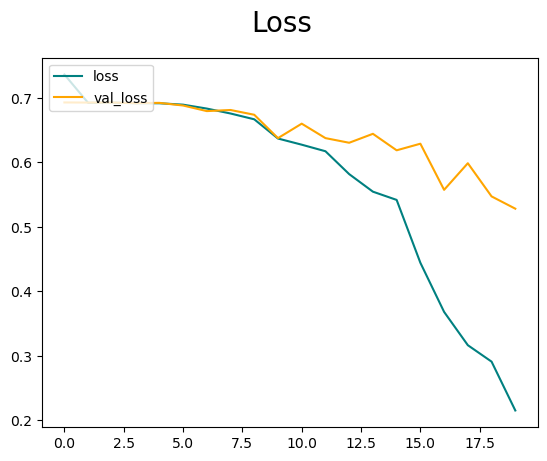

In [234]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

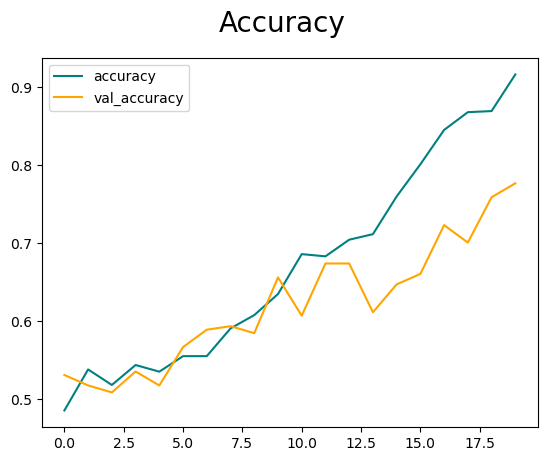

In [235]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. 评估模型

In [195]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [196]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [197]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    yhat = np.where(yhat > 0.5, 1, 0)  # 转为0/1
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 29ms/step


In [198]:
print(f'精确率：{pre.result().numpy()},召回率： {re.result().numpy()}, 准确率：{acc.result().numpy()}')

精确率：0.8053097128868103,召回率： 0.8125, 准确率：0.7962085604667664


# 10. 测试

In [199]:
import cv2

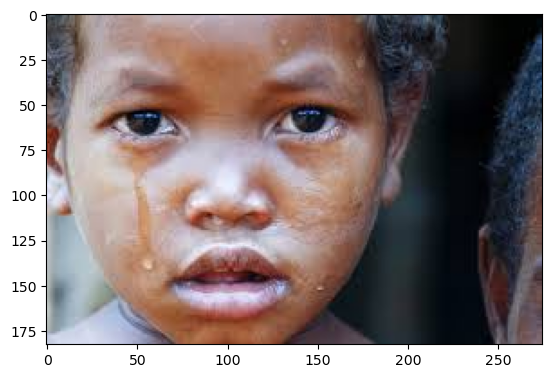

In [200]:
img = cv2.imread('sad_test3.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

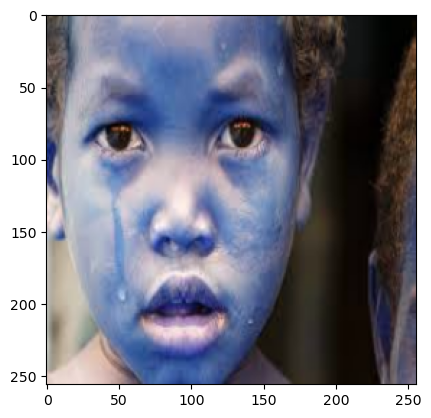

In [201]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [202]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 18ms/step


In [203]:
yhat

array([[0.86239946]], dtype=float32)

In [157]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad
